# Fitting

In [ ]:
import sys
sys.path.insert(0, '../../src/')

import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import Operator
from tqdm.notebook import tqdm

from kraus_channels import KrausMap, isomery_to_kraus
from loss_functions import ProbabilityMSE, ProbabilityRValue
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import channel_fidelity
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits, marginalize_counts
from spam import SPAM, InitialState, CorruptionMatrix
from utils import saver
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, complex_spacing_ratio
from quantum_circuits import integrable_circuit


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
def integrable_circuit(n, L):
    theta_list = [np.random.uniform(-np.pi, np.pi, n) for i in range(L)]
    sqrt_iSWAP = iSwapGate().power(1 / 2)

    circuit = qk.QuantumCircuit(n)
    for i, theta in enumerate(theta_list):

        offset = i%2
        for j in range(n):
            circuit.rz(theta[j], j)

        for j in range((n - offset) // 2):
            circuit.append(sqrt_iSWAP, [2 * j + offset, 2 * j + 1 + offset])


    return circuit


def nonintegrable_circuit(n, L):
    theta_list = [np.random.uniform(-np.pi, np.pi, 2*n) for i in range(L)]
    sqrt_iSWAP = iSwapGate().power(1 / 2)

    circuit = qk.QuantumCircuit(n)
    for i, theta in enumerate(theta_list):

        offset = i%2
        for j in range(n):
            circuit.ry(theta[j], j)
            circuit.rz(theta[j+n], j)

        for j in range((n - offset) // 2):
            circuit.append(sqrt_iSWAP, [2 * j + offset, 2 * j + 1 + offset])


    return circuit

In [3]:
def load_data(filename, n, seed, L):
    with open(filename, 'rb') as f:
        data = pkl.load(f)


    data = marginalize_counts(data, 0)

    targets = counts_to_probs(data)
    targets_spam = targets[:6**n]
    targets_map = targets[6**n:]

    np.random.seed(seed)
    
    circuit_target = integrable_circuit(n+1, L)
    unitary = Operator(circuit_target).data

    inputs_spam, _ = generate_pauliInput_circuits(n)
        
    inputs_map, circuit_list_map = (
                generate_pauli_circuits(n, None, N=5000-6**n)
        )
    
    return inputs_spam, targets_spam, inputs_map, targets_map, unitary

def fit_spam(inputs, 
             targets,
             num_iter = 3000,
             verbose = False):
    d = targets.shape[1]
    spam_model = SPAM(init = InitialState(d),
                    povm = CorruptionMatrix(d),
                    )

    spam_opt = ModelSPAM(spam_model, tf.keras.optimizers.Adam(learning_rate=0.01))
        
    spam_opt.pretrain(100, verbose=False)

    spam_opt.train(inputs = inputs,
                    targets = targets,
                    num_iter = num_iter,
                    verbose = verbose,
                )
    
    return spam_model
    

def fit_model(inputs, 
              targets, 
              spam_model,
              num_iter = 3000,
              verbose=False):
    d = targets.shape[1]
    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                        rank = d**2,
                                        spam = spam_model,
                                        ),
                    loss_function = ProbabilityMSE(),
                    optimizer = tf.optimizers.Adam(learning_rate=0.01),
                    logger = Logger(loss_function_list = [ProbabilityRValue()], sample_freq=100),
                )

    model.train(inputs = inputs,
                targets = targets,
                inputs_val = [inputs],
                targets_val = [targets],
                num_iter = num_iter,
                N = 500,
                verbose=verbose
                )
    
    return model

In [ ]:
path = 'data/chaos_exp_reorder/5q/integrable_L=40/'
n = 4
d = 2**n
L = 40

spam_list = []
model_list = []

for i in tqdm(range(10)):
    seed = 42 + i
    inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data(path + f'seed_{seed}.pkl', n, seed, L)
    spam_model = fit_spam(inputs_spam, targets_spam, verbose=True)
    spam_list.append(spam_model) 

    model = fit_model(inputs_map, 
                     targets_map, 
                     spam_model, 
                     verbose=True)
    model_list.append(model)

model_saver(spam_list, f'models/integrable_spam_{n}_L=40_reorder.model')
model_saver(model_list, f'models/integrable_model_{n}_L=40_reorder.model')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.05032380380621751 
0.00044920939717298054 
9.340397859424032e-05 
8.470825630338774e-05 
7.964674175205362e-05 
7.67581960362796e-05 
7.501421522009665e-05 
7.384633470365106e-05 
7.306409302813815e-05 
7.249932745047576e-05 
7.202359381711513e-05 
7.17336983226548e-05 
7.147331903503789e-05 
7.126041580189018e-05 
7.112193559117918e-05 
7.094554187677931e-05 
7.085706912873894e-05 
7.078616035376516e-05 
7.071441199410086e-05 
7.06489709238424e-05 
7.061071421984759e-05 
7.057731713300562e-05 
7.05238746275306e-05 
7.04964227290018e-05 
7.047099775375145e-05 
7.046460042141377e-05 
7.044747467920733e-05 
7.042924556645882e-05 
7.041951439917738e-05 
7.041058727907846e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.006654705282791662]
[0.7574023834997318]
[0.9529377116522179]
[0.9775283287386394]
[0.9838561144365902]
[0.9866805245873975]
[0.9882732004013858]
[0.9893123828694533]
[0.990032228976981]
[0.9905671429373653]
[0.9909800457469448]
[0.9912982183270723]
[0.9915550824888214]
[0.9917731499087948]
[0.9919470524503312]
[0.9920987228982524]
[0.9922164526104893]
[0.9923328072722917]
[0.9924322679074989]
[0.9925026712531461]
[0.9925837185204321]
[0.9926445229276067]
[0.9926930306270588]
[0.9927431636058174]
[0.9927803088014632]
[0.9928155970531788]
[0.9928477370479093]
[0.9928966736163595]
[0.9929285448588578]
[0.9929459854167306]
[0.9929507651123234]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.07337197300351744 
0.0023643476773701107 
0.00010061757553039572 
8.692052573291963e-05 
8.04562789800169e-05 
7.711579580224184e-05 
7.509618374009614e-05 
7.393730020531164e-05 
7.312734319748106e-05 
7.25851896836293e-05 
7.219348918932718e-05 
7.181644007644476e-05 
7.155247285723603e-05 
7.134426462941188e-05 
7.116711144822222e-05 
7.104157869837844e-05 
7.091920875011419e-05 
7.083663973055347e-05 
7.075703356544368e-05 
7.069688048207423e-05 
7.063274317602607e-05 
7.059476368986e-05 
7.057183948272429e-05 
7.05309773118233e-05 
7.049670221383405e-05 
7.045781493963297e-05 
7.043816821805387e-05 
7.043502280351984e-05 
7.040387049105165e-05 
7.039416057700977e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.001483091005316739]
[0.7575357194024501]
[0.9542857034772385]
[0.9778450772978841]
[0.9831622834303816]
[0.9856265503816649]
[0.9870637161330458]
[0.9880378923544675]
[0.9887263373928851]
[0.9892428583738033]
[0.9896485338070621]
[0.989968852452186]
[0.9902155476916471]
[0.9904365720898984]
[0.9906095779248225]
[0.9907711596552191]
[0.9909016352158588]
[0.9909947983837069]
[0.9910880405172154]
[0.9911751626263168]
[0.9912570203161155]
[0.9913182197608117]
[0.9913702212217015]
[0.9914254447258735]
[0.9914642736961495]
[0.991493431765909]
[0.9915303417535648]
[0.991566973010001]
[0.9915970609156848]
[0.9916295955762751]
[0.9916359458565772]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.06588877408990625 
0.001357009893484952 
0.000164973530842798 
0.00012080587971911278 
9.984564096295669e-05 
8.91636388348194e-05 
8.322895012037578e-05 
7.9444492091936e-05 
7.704936593431718e-05 
7.54720989362902e-05 
7.426357718420228e-05 
7.347538136356864e-05 
7.284357141074119e-05 
7.244341712820094e-05 
7.197581297385653e-05 
7.170383622367754e-05 
7.141596377992942e-05 
7.127848860083175e-05 
7.110822722769041e-05 
7.096405279405958e-05 
7.089073710257098e-05 
7.07646820504418e-05 
7.070063164159574e-05 
7.064742252227943e-05 
7.059662756951987e-05 
7.054809675662022e-05 
7.050319256459563e-05 
7.047951378596593e-05 
7.046433853113271e-05 
7.043796114352392e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.006267038733512642]
[0.7402243277346703]
[0.9519934125437786]
[0.9772774012388505]
[0.9829018857904853]
[0.9854126136488728]
[0.9868862084042179]
[0.9878769181207194]
[0.9885822204081398]
[0.9891099002058885]
[0.9895245101071724]
[0.9898512520733067]
[0.9901156049941604]
[0.9903435592877444]
[0.9905262853664432]
[0.9906867863147035]
[0.9908294952456511]
[0.9909531383451082]
[0.9910462118032236]
[0.9911423694420544]
[0.9912181511423368]
[0.9912832146048441]
[0.9913259090039358]
[0.9913978996560547]
[0.9914252009162865]
[0.9914879295226589]
[0.9915173283834774]
[0.9915484562781638]
[0.9915776629583551]
[0.9916088395987794]
[0.9916209193669019]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.06743073280221251 
0.0010003339729930262 
8.916419784693412e-05 
8.240339008668351e-05 
7.842793267362949e-05 
7.609237379552877e-05 
7.451902216734115e-05 
7.357276007168224e-05 
7.282269314931025e-05 
7.227152057339708e-05 
7.191021993885408e-05 
7.164603003144003e-05 
7.138268180695944e-05 
7.119642302557702e-05 
7.106229967516026e-05 
7.096727388481869e-05 
7.085676434122843e-05 
7.078482923698776e-05 
7.070162928343482e-05 
7.066751686701138e-05 
7.059017263555788e-05 
7.055305093375938e-05 
7.052204359454968e-05 
7.04955978163981e-05 
7.046247335438961e-05 
7.045507136369284e-05 
7.042929610946662e-05 
7.041617760650155e-05 
7.040094930535659e-05 
7.039557350333993e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.009692621713403238]
[0.7399976897230311]
[0.9548733380359832]
[0.9782185430228348]
[0.9834924745384633]
[0.9858213104640345]
[0.9871915070568429]
[0.9880989183796421]
[0.9887395916910927]
[0.9892270291148648]
[0.9896182949157691]
[0.9899192476729747]
[0.9901635927695036]
[0.9903611701303737]
[0.9905377983874157]
[0.9906952791109341]
[0.9908183396390857]
[0.9909226144397132]
[0.9910089437339316]
[0.991094533968395]
[0.9911662688921017]
[0.9912105981334562]
[0.991278317089529]
[0.991337592105562]
[0.9913753207436607]
[0.991408038166679]
[0.9914375268096747]
[0.9914474957895534]
[0.9914822250925341]
[0.9914942525472776]
[0.9915380105567689]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.0626140591424531 
0.0010037109261349455 
9.016890335987597e-05 
8.31954084895219e-05 
7.91614554038157e-05 
7.647931140196179e-05 
7.488676236011228e-05 
7.381269652767319e-05 
7.303154993199737e-05 
7.243291816852869e-05 
7.200872872058543e-05 
7.16373152546715e-05 
7.141476846479067e-05 
7.122392540349215e-05 
7.106173989053282e-05 
7.093540965947198e-05 
7.08397944513955e-05 
7.076985073865129e-05 
7.066849535666627e-05 
7.06271145082479e-05 
7.058409337811697e-05 
7.057865786619303e-05 
7.051638838433863e-05 
7.049134885062678e-05 
7.047392535317125e-05 
7.045472438422714e-05 
7.042949832765418e-05 
7.043348583229844e-05 
7.042750577486467e-05 
7.039204806342913e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.010989709088444988]
[0.7316845913583181]
[0.944532562084484]
[0.9775211877747279]
[0.9845741230806317]
[0.9874319732428506]
[0.989000308008693]
[0.9900079794060858]
[0.990700872855138]
[0.991220684795942]
[0.9916123399848457]
[0.991931951160155]
[0.9921801851768314]
[0.9923972207647054]
[0.9925752428828022]
[0.9927189796437981]
[0.9928471053445632]
[0.9929570243264028]
[0.993042351099583]
[0.993126497157172]
[0.9931972172335042]
[0.9932630620781316]
[0.9933173110715964]
[0.9933668347902941]
[0.9934177486021305]
[0.9934629362772379]
[0.9934904942550605]
[0.9935227044201309]
[0.9935520122859077]
[0.9935815115897555]
[0.9935977118915638]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.07939660276729825 
0.0012515207733180148 
0.00010588150954502377 
9.220624574060148e-05 
8.486777191979193e-05 
8.069325233284447e-05 
7.803937456441013e-05 
7.614852366464473e-05 
7.499537906423292e-05 
7.403022892412417e-05 
7.329160989594186e-05 
7.275294037667473e-05 
7.23101565753469e-05 
7.196208977535616e-05 
7.168913087091049e-05 
7.147131355774235e-05 
7.127281046168026e-05 
7.11450947183561e-05 
7.099056666623394e-05 
7.091692047916373e-05 
7.083790695231456e-05 
7.076377273790482e-05 
7.070111839242042e-05 
7.064627329961635e-05 
7.061615930948672e-05 
7.056377922227246e-05 
7.051601207282111e-05 
7.050604714785995e-05 
7.046945074880188e-05 
7.046079518760104e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.00894677286711243]
[0.7534892329283369]
[0.95453566298562]
[0.9755554339656998]
[0.9806877337162615]
[0.9831761869494692]
[0.9846626287150183]
[0.9856628057063408]
[0.9863910487404558]
[0.986943436771589]
[0.9873731019994249]
[0.987724663287653]
[0.9879962399202523]
[0.9882360547379393]
[0.9884359604766781]
[0.9886098160108556]
[0.9887459911580423]
[0.9888603801196592]
[0.9889633362353094]
[0.9890664416589882]
[0.9891562340587282]
[0.9892118229577271]
[0.9892830376830658]
[0.9893384788523591]
[0.9893790790697514]
[0.9894025730017649]
[0.9894603858883867]
[0.9894781209758328]
[0.9895206626260803]
[0.9895564090723695]
[0.9895545514062993]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.051279428156788834 
0.0010275778517126136 
0.00013500370030424113 
9.108787991548844e-05 
8.125406552947443e-05 
7.672689417435645e-05 
7.46923220533782e-05 
7.333031017697261e-05 
7.262594143043852e-05 
7.208851141253202e-05 
7.178388851600273e-05 
7.150965305033863e-05 
7.129176267186293e-05 
7.1148903203037e-05 
7.101572929782971e-05 
7.09353322284194e-05 
7.08328391587445e-05 
7.075904142551951e-05 
7.070324948246009e-05 
7.064006711798438e-05 
7.059394650900519e-05 
7.055563225897975e-05 
7.052304828632005e-05 
7.049264400660904e-05 
7.046924576536378e-05 
7.04551329298668e-05 
7.042095373648773e-05 
7.041281126904114e-05 
7.041076514230865e-05 
7.038587977249818e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.0032665521160530897]
[0.772860746102749]
[0.9612531689590195]
[0.9825324460204191]
[0.9873638280483835]
[0.9894756107769359]
[0.9906859197084229]
[0.991466680487801]
[0.9920141172443039]
[0.9924284650802617]
[0.9927472928949186]
[0.9929971664760886]
[0.9932033622832322]
[0.9933653882469379]
[0.9935146508990425]
[0.9936326903801384]
[0.9937319562020014]
[0.9938198902243356]
[0.9939023974943785]
[0.9939718565136794]
[0.9940296222321248]
[0.994079503670978]
[0.9941261275496411]
[0.9941607318489736]
[0.9941943284415538]
[0.9942144729565]
[0.9942561483785898]
[0.9942874295516]
[0.9943090812577974]
[0.9943336828839582]
[0.9943343342113434]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.06212657542622598 
0.0010074613856713237 
9.78640413126646e-05 
8.519745432499516e-05 
7.965850976288478e-05 
7.664730397945795e-05 
7.493991315004325e-05 
7.378151400556796e-05 
7.303641656106652e-05 
7.24947726098276e-05 
7.213505096542245e-05 
7.17499988166124e-05 
7.156242142030936e-05 
7.132548272790826e-05 
7.116378839763537e-05 
7.101716863095046e-05 
7.092907180206382e-05 
7.081189242583772e-05 
7.077075961848576e-05 
7.068818919591088e-05 
7.061991214495905e-05 
7.056770413390615e-05 
7.05561899127432e-05 
7.051989121193631e-05 
7.047389454637263e-05 
7.045234382343033e-05 
7.044073203565316e-05 
7.044285589946601e-05 
7.040004989569501e-05 
7.040022092595513e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.0012202124970963624]
[0.8010444195016774]
[0.9511890835897295]
[0.9702799473628346]
[0.9757002521382844]
[0.9782591609326557]
[0.9797900198799064]
[0.9808126888292448]
[0.9815573476966339]
[0.9821158992224097]
[0.9825492420708857]
[0.9829111056493258]
[0.9832104304471154]
[0.9834428798645457]
[0.983622171233796]
[0.9837979067298249]
[0.9839696435992593]
[0.9840524723255696]
[0.9841749394942463]
[0.9842658953374492]
[0.9843338306383886]
[0.9844094727407281]
[0.9844457386743507]
[0.9845126850037206]
[0.9845869584665224]
[0.9846195154427839]
[0.9846410623692033]
[0.9846870849236582]
[0.9847097868129847]
[0.9847443843321776]
[0.9847621224196154]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.07242141072861882 
0.003930350102462073 
0.00029536100022695003 
8.046909287027692e-05 
7.404711488042599e-05 
7.323078926689263e-05 
7.263225862475093e-05 
7.217786489902203e-05 
7.182904050425966e-05 
7.156221004306164e-05 
7.137639052035274e-05 
7.119003648993645e-05 
7.105604210369357e-05 
7.094306772830223e-05 
7.084886900011824e-05 
7.078109299164966e-05 
7.072197315613302e-05 
7.065259816571821e-05 
7.060642275010228e-05 
7.05680534791098e-05 
7.055106616756517e-05 
7.051814665759088e-05 
7.05030183754477e-05 
7.045234027008154e-05 
7.04374555151479e-05 
7.041867997746855e-05 
7.040762719312691e-05 
7.039784383558893e-05 
7.036844938870568e-05 
7.038336181175164e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.026242193134022873]
[0.7427031911187127]
[0.9367262643994545]
[0.962093816684483]
[0.9689375756481787]
[0.9721824133059433]
[0.9741427352421387]
[0.9754902246238041]
[0.9764652673903592]
[0.9771956910251913]
[0.9777878831829917]
[0.9782582667251702]
[0.9786180698714689]
[0.9789555653883725]
[0.9792350979992536]
[0.9794599999922696]
[0.9796304569442471]
[0.9797854828050353]
[0.9799349287921407]
[0.9800412129391873]
[0.9801321044510345]
[0.980213481562518]
[0.980334180667946]
[0.9803638110144356]
[0.9804522392917906]
[0.9805125142256397]
[0.9805516196657589]
[0.9805486762134619]
[0.9806174576758094]
[0.980670887338247]
[0.980661860119904]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.0720390460451575 
0.0015001204766844577 
0.0001365130580022957 
0.00010450158826440661 
9.065896180056562e-05 
8.346574293778099e-05 
7.952146798364755e-05 
7.703583738078e-05 
7.555023168947584e-05 
7.444510842917898e-05 
7.365780704847387e-05 
7.307422619157572e-05 
7.258241471568351e-05 
7.221683587602421e-05 
7.193344543774964e-05 
7.16916371611989e-05 
7.149266528921383e-05 
7.1311422099148e-05 
7.11939378667323e-05 
7.107293285278811e-05 
7.094919134028105e-05 
7.085670062259312e-05 
7.079072734699218e-05 
7.072603721986719e-05 
7.06791669447213e-05 
7.063409732805199e-05 
7.059204646299329e-05 
7.05572240291122e-05 
7.052147573169839e-05 
7.049758238483601e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.0009883819114269166]
[0.7606404085865924]
[0.9499957091767125]
[0.9742022525037354]
[0.9802094689458338]
[0.9829597951877648]
[0.9845443456654471]
[0.9855867837695508]
[0.9863497198798711]
[0.9869274475136844]
[0.9873606411055414]
[0.9877051240513778]
[0.9879919130942231]
[0.9882148712879743]
[0.9884256003653743]
[0.9886005510587232]
[0.9887320876062803]
[0.9888464841623029]
[0.9889758235441233]
[0.9890605607749454]
[0.9891146050729307]
[0.9892191683965356]
[0.9892661435285501]
[0.989323212177097]
[0.9893682022053429]
[0.989412481220431]
[0.989465807712232]
[0.989483579660501]
[0.9895339682475986]
[0.9895424510019611]
[0.989589386817671]


## Retrieve CSR

### L = 20

In [5]:
n = 4

model_list = pkl.load(open(f'models/integrable_model_{n}_L=40_reorder.model', 'rb'))

loss_list = []
spectrum_list = []
csr_integrable_list = []
for model in model_list:
    loss = model.logger.loss_list[0][-1]
    loss_list.append(loss)

    channel = model.channel
    spectrum = channel_spectrum(channel)

    csr = complex_spacing_ratio(spectrum)

    spectrum_list.append(spectrum)
    csr_integrable_list.append(csr)

csr_integrable = Spectrum(csr_integrable_list)

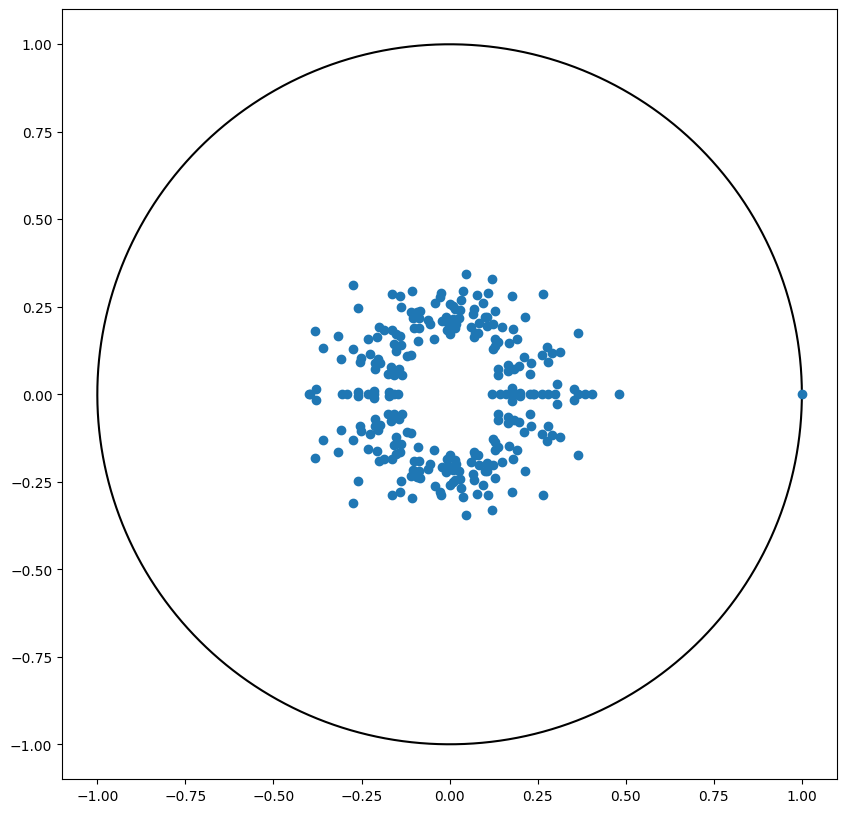

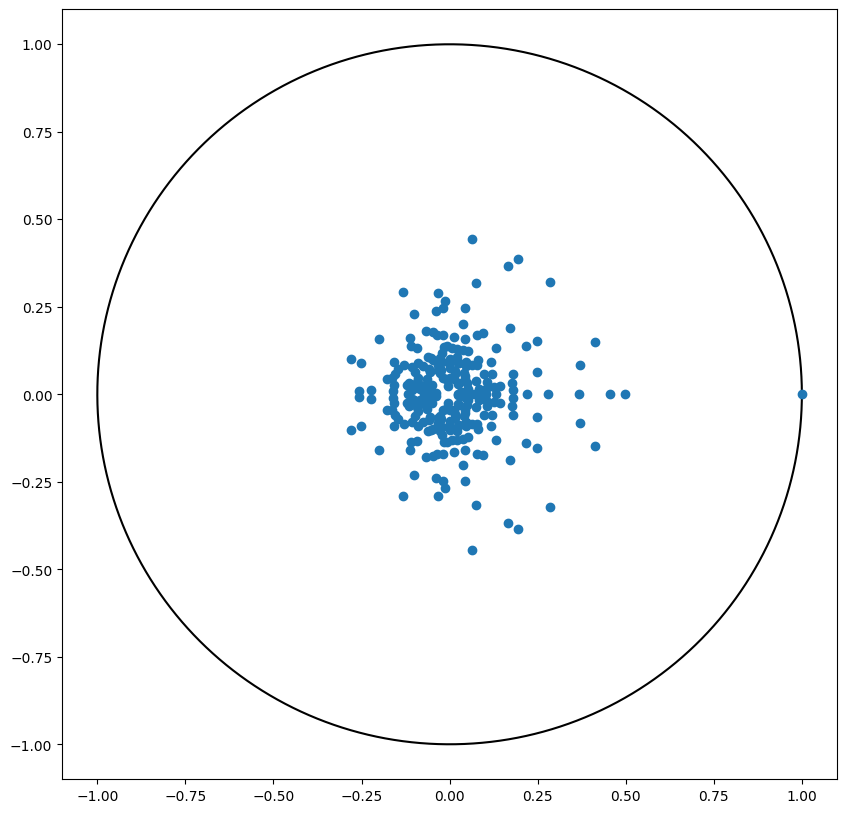

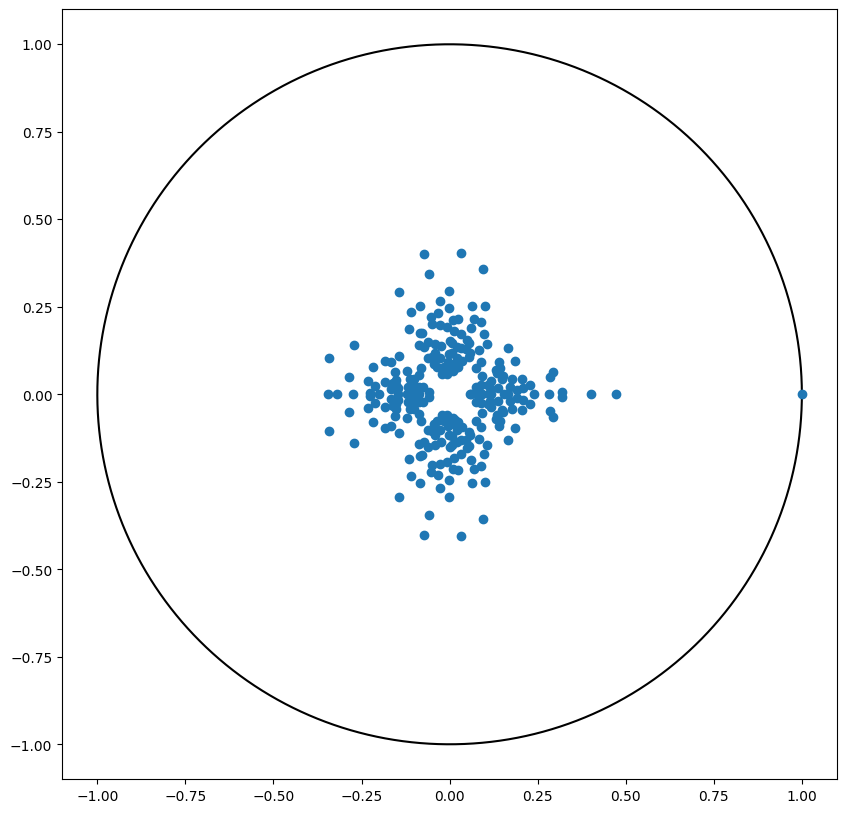

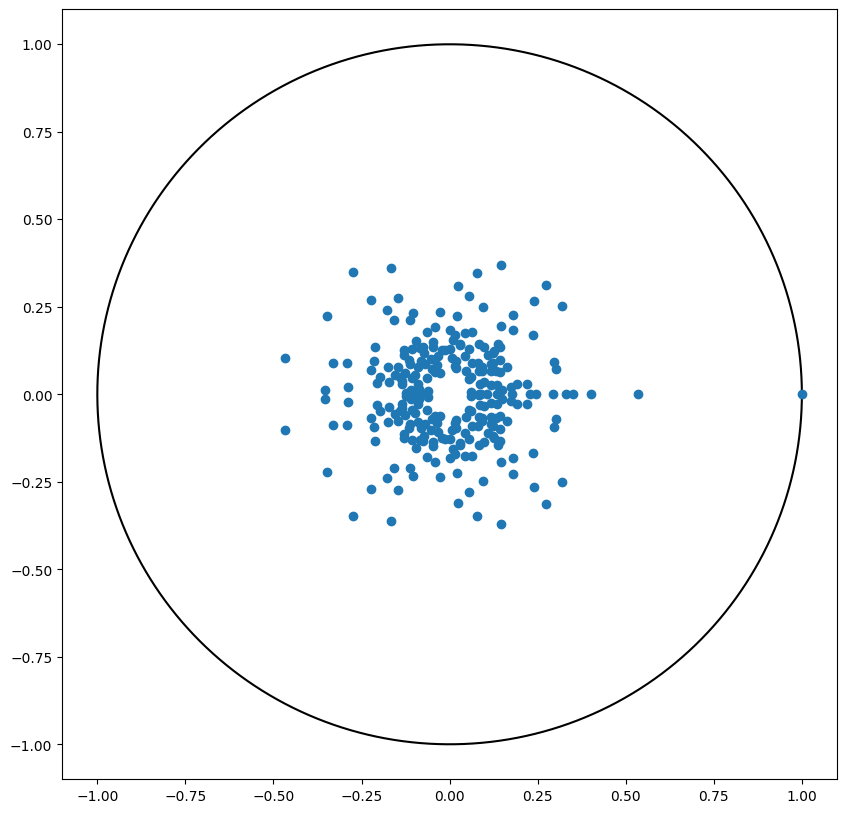

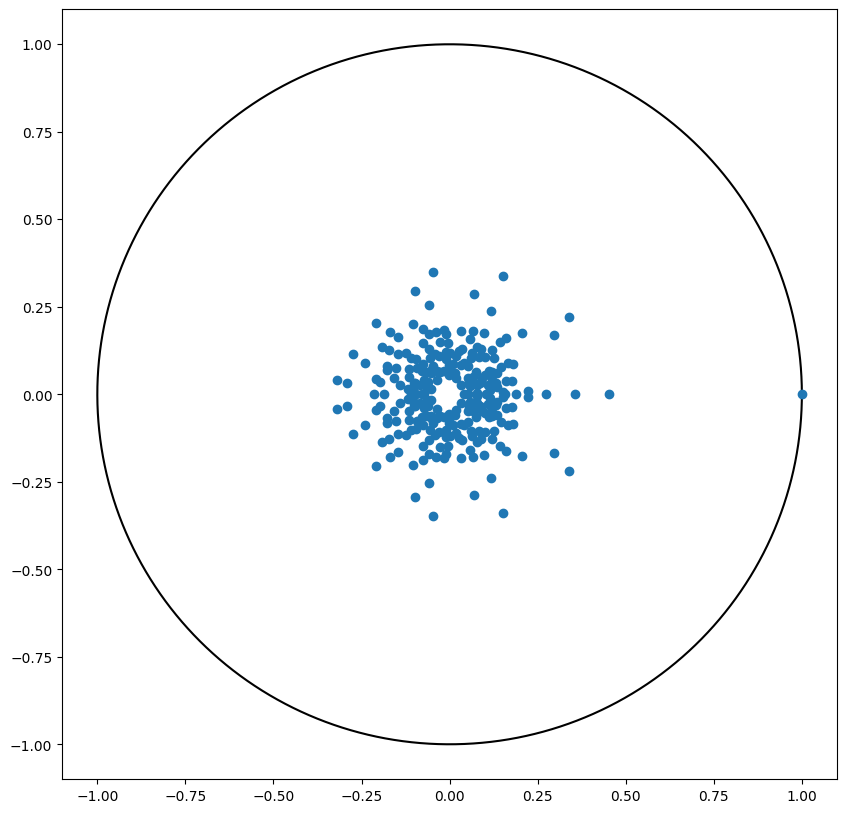

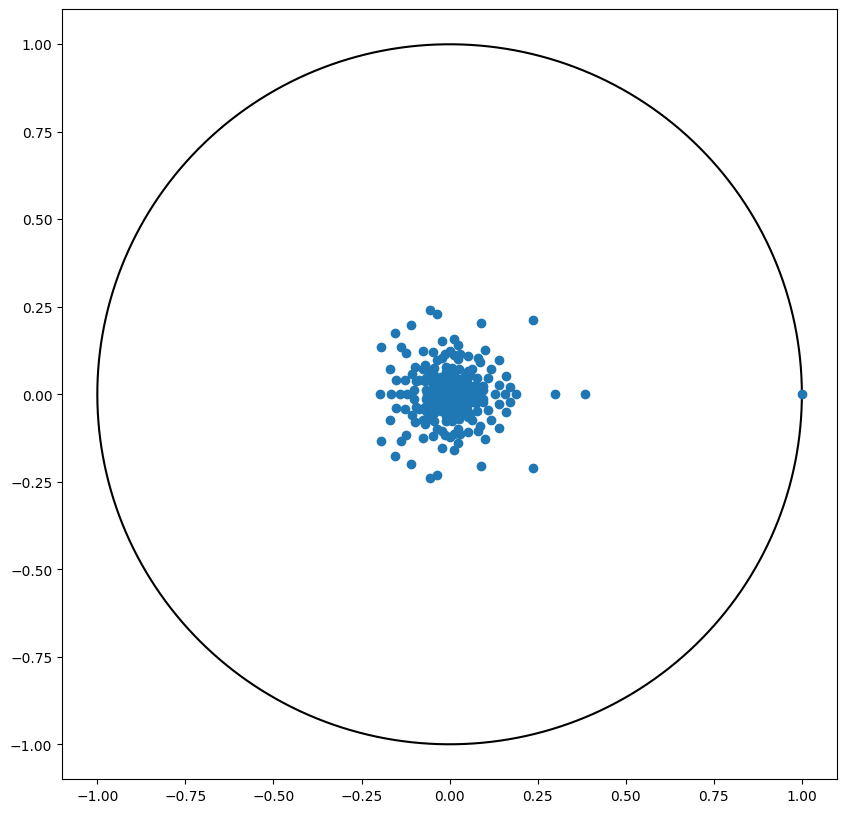

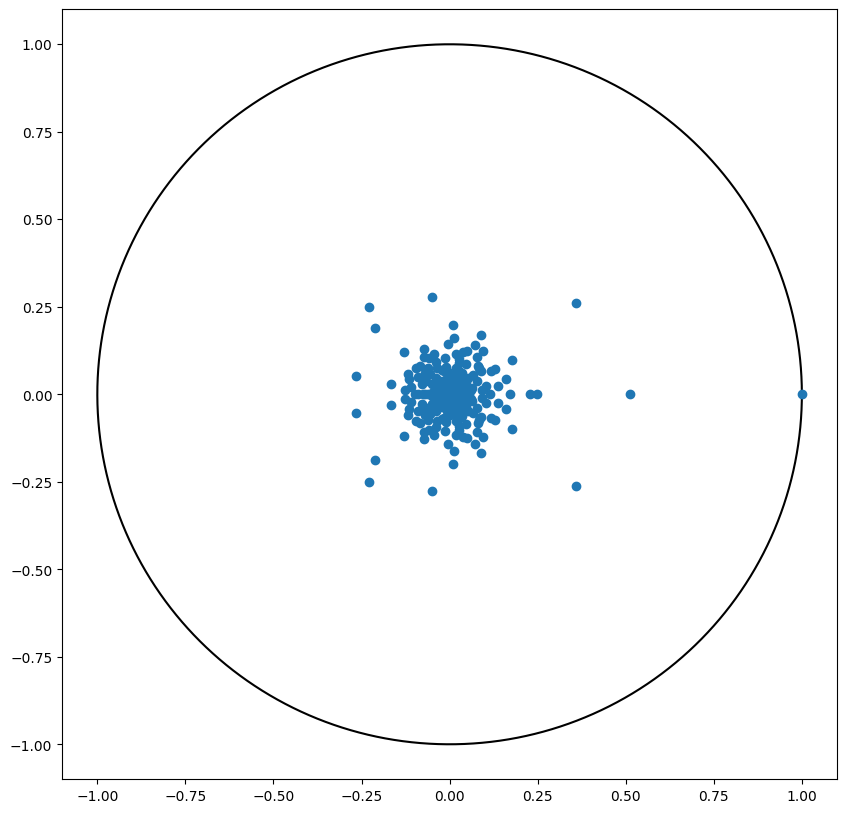

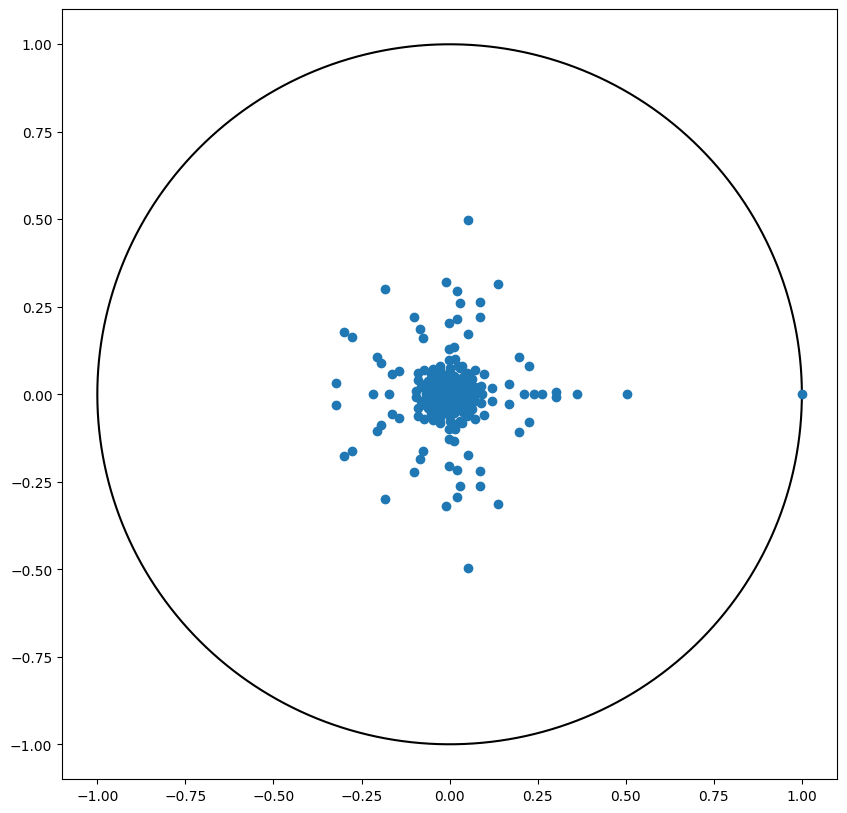

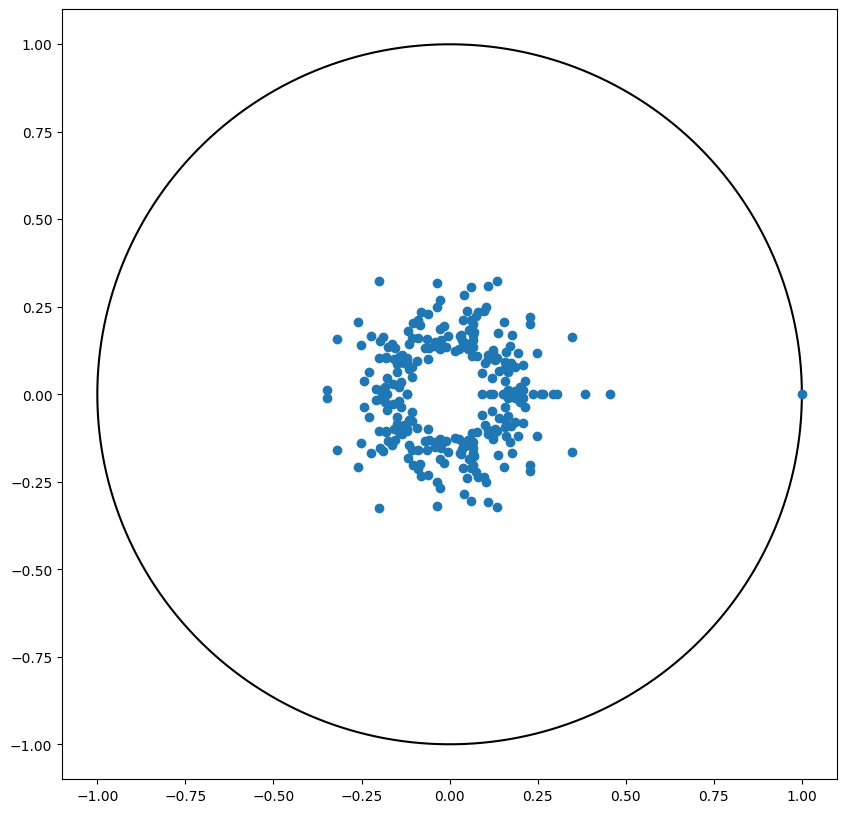

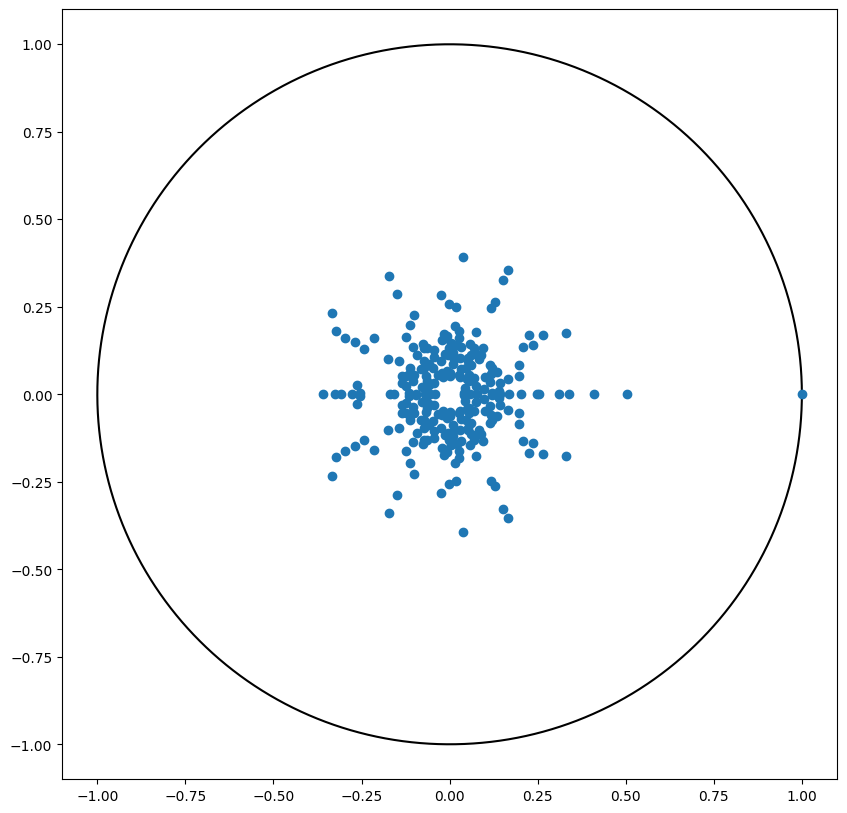

In [6]:
for spectrum in spectrum_list:
    spectrum.plot_circle()
    spectrum.plot()
    plt.show()

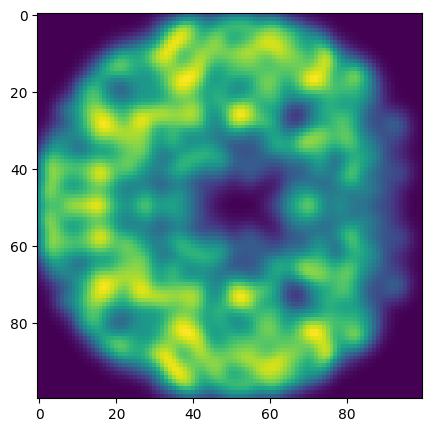

In [7]:
csr_integrable_coat = coat_spectrum(csr_integrable, sigma = 0.05)

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_integrable_coat)
plt.savefig('figures/integrable_crs_retrieved_L=40.png')
plt.show()

In [10]:
loss_mean = np.mean(loss_list)
loss_std = np.std(loss_list)

print(f'Loss mean: {loss_mean}, Loss std: {loss_std}')

Loss mean: 0.9918681256668321, Loss std: 0.0017883331206181587
